<a href="https://colab.research.google.com/github/markgermano/planets/blob/main/reproduce_lactate_load/analyze/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'sublime-seat-354718'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')


In [9]:
df = run_query(f'''
WITH tally AS (
SELECT ie.subject_id, ie.stay_id, ie.hadm_id
, SUM(CASE WHEN DATE_DIFF(ce.charttime, ie.intime, HOUR) <= 24 AND DATE_DIFF(ce.charttime, ie.intime, HOUR) >= 0 THEN 1 ELSE 0 END) as count_
, MAX(ce.valuenum) AS max
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_hosp.labevents` ce
    ON ie.hadm_id = ce.hadm_id
WHERE itemid in (50813, 52442)
GROUP BY subject_id, stay_id, hadm_id
)

SELECT ie.subject_id, ie.hadm_id, ie.stay_id
, CASE WHEN age.anchor_age >= 18 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN ROW_NUMBER() OVER (PARTITION BY ie.subject_id ORDER BY ie.intime) > 1 THEN 1 ELSE 0 END AS exclude_not_first_icu
, CASE WHEN COALESCE(tally.count_, 0) < 2 THEN 1 ELSE 0 END AS exclude_not_2_lactate
, CASE WHEN DATE_DIFF(ie.outtime, ie.intime, HOUR) < 24 THEN 1 ELSE 0 END AS exclude_short_los
, CASE WHEN sep.sepsis3 = TRUE AND DATE_DIFF(sep.suspected_infection_time, ie.intime, HOUR) < 0 THEN 1 ELSE 0 END AS sepsis
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_core.patients` age
    ON ie.subject_id = age.subject_id
LEFT JOIN tally
   ON ie.stay_id = tally.stay_id
LEFT JOIN `physionet-data.mimic_derived.sepsis3` AS sep
  ON ie.stay_id = sep.stay_id
WHERE max IS NOT NULL
ORDER BY subject_id, hadm_id, stay_id
''')

display(df)

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_not_first_icu,exclude_not_2_lactate,exclude_short_los,sepsis
0,10001884,26184834,37510196,0,0,0,0,1
1,10002013,23581541,39060235,0,0,0,0,0
2,10002155,20345487,32358465,0,0,0,1,0
3,10002348,22725460,32610785,0,0,1,0,0
4,10002428,20321825,34807493,0,1,0,0,1
...,...,...,...,...,...,...,...,...
53060,19999297,21439025,37364566,0,0,1,0,1
53061,19999442,26785317,32336619,0,0,0,0,0
53062,19999625,25304202,31070865,0,0,0,1,1
53063,19999828,25744818,36075953,0,0,1,0,0


In [10]:
df = df.loc[(df['exclude_non_adult'] == 0) & (df['exclude_not_first_icu'] == 0) & (df['exclude_not_2_lactate'] == 0) & (df['exclude_short_los'] == 0)]

print(df)

       subject_id   hadm_id   stay_id  exclude_non_adult  \
0        10001884  26184834  37510196                  0   
1        10002013  23581541  39060235                  0   
6        10002428  28662225  33987268                  0   
8        10002443  21329021  35044219                  0   
9        10002495  24982426  36753294                  0   
...           ...       ...       ...                ...   
53051    19997843  20277361  32880062                  0   
53052    19997886  20793010  37403074                  0   
53054    19998591  24349193  36794489                  0   
53056    19998843  24842066  30988867                  0   
53061    19999442  26785317  32336619                  0   

       exclude_not_first_icu  exclude_not_2_lactate  exclude_short_los  sepsis  
0                          0                      0                  0       1  
1                          0                      0                  0       0  
6                          0        

In [11]:
df.sum()

subject_id               266282175266
hadm_id                  444240719332
stay_id                  622229973703
exclude_non_adult                   0
exclude_not_first_icu               0
exclude_not_2_lactate               0
exclude_short_los                   0
sepsis                           5850
dtype: int64

In [12]:
df_lac = run_query(f'''
SELECT ie.subject_id, ie.stay_id, ie.hadm_id, ce.valuenum
, DATE_DIFF(ce.charttime, ie.intime, HOUR) AS time
, MAX(ce.valuenum) OVER (PARTITION BY ie.stay_id) as max_lactate
, AVG(ce.valuenum) OVER (PARTITION BY ie.stay_id) as mean_lactate
, RANK() OVER (PARTITION BY ie.stay_id ORDER BY ce.charttime) AS rank
FROM `physionet-data.mimic_icu.icustays` ie
INNER JOIN `physionet-data.mimic_hosp.labevents` ce
    ON ie.hadm_id = ce.hadm_id
WHERE itemid in (50813, 52442)
AND DATE_DIFF(ce.charttime, ie.intime, HOUR) <= 24 AND DATE_DIFF(ce.charttime, ie.intime, HOUR) >= 0
ORDER BY subject_id, hadm_id, stay_id
''')

display(df_lac)

,subject_id,stay_id,hadm_id,valuenum,time,max_lactate,mean_lactate,rank
0,10001884,37510196,26184834,1.5,2,1.5,1.300000,1
1,10001884,37510196,26184834,1.1,7,1.5,1.300000,2
2,10002013,39060235,23581541,3.3,0,3.3,2.950000,1
3,10002013,39060235,23581541,2.8,1,3.3,2.950000,2
4,10002013,39060235,23581541,3.1,2,3.3,2.950000,3
...,...,...,...,...,...,...,...,...
118024,19999442,32336619,26785317,2.0,12,3.0,2.266667,2
118025,19999442,32336619,26785317,1.8,14,3.0,2.266667,3
118026,19999625,31070865,25304202,2.3,4,2.3,1.750000,1
118027,19999625,31070865,25304202,1.2,20,2.3,1.750000,2


In [13]:
new_data = df_lac.groupby('stay_id')
lac_load = pd.DataFrame(columns=['max_lac', 'mean_lac', 'lac_load', 'norm_lac_load', 'stay_id'])
lac_load_list = []
norm_lac_list = []
stay_id_list = []
max_lac_list = []
mean_lac_list = []

for group, item in new_data:
  sum = 0
  for v1, v2, rank1, rank2, t1, t2 in zip(new_data.get_group(group)['valuenum'], new_data.get_group(group)['valuenum'][1:], new_data.get_group(group)['rank'], new_data.get_group(group)['rank'][1:], new_data.get_group(group)['time'], new_data.get_group(group)['time'][1:]):
    if rank1 == 1:
      sum+=(((v1+v1)/2)*(t1-0))
    if rank2 == new_data.get_group(group)['rank'].iloc[-1]:
      sum+=(((v2+v2)/2)*(24-t2))
    sum+=(((v1+v2)/2)*(t2-t1))
  max_lac_list.append(max(new_data.get_group(group)['max_lactate']))
  mean_lac_list.append(max(new_data.get_group(group)['mean_lactate']))
  lac_load_list.append(sum)
  norm_lac_list.append(sum/24)
  stay_id_list.append(group)

lac_load = pd.DataFrame({'max_lac': max_lac_list, 'mean_lac': mean_lac_list,'lac_load': lac_load_list, 'norm_lac_load': norm_lac_list, 'stay_id': stay_id_list})

print(lac_load.head())

   max_lac  mean_lac  lac_load  norm_lac_load   stay_id
0      2.1       1.7      49.2       2.050000  30000153
1      0.9       0.9       0.0       0.000000  30000213
2      2.0       1.8      41.6       1.733333  30000484
3      1.6       1.6      38.4       1.600000  30000646
4      1.5       1.5       0.0       0.000000  30001148


In [14]:
df_merged = pd.merge(df, lac_load, on='stay_id')

print(df_merged)

       subject_id   hadm_id   stay_id  exclude_non_adult  \
0        10001884  26184834  37510196                  0   
1        10002013  23581541  39060235                  0   
2        10002428  28662225  33987268                  0   
3        10002443  21329021  35044219                  0   
4        10002495  24982426  36753294                  0   
...           ...       ...       ...                ...   
17777    19997843  20277361  32880062                  0   
17778    19997886  20793010  37403074                  0   
17779    19998591  24349193  36794489                  0   
17780    19998843  24842066  30988867                  0   
17781    19999442  26785317  32336619                  0   

       exclude_not_first_icu  exclude_not_2_lactate  exclude_short_los  \
0                          0                      0                  0   
1                          0                      0                  0   
2                          0                      0      

In [331]:
df_merged["lac_load"].mean()

55.911777401000066

In [332]:
df_merged["norm_lac_load"].mean()

2.3296573917083356

In [103]:
df_merged["max_lac"].mean()

3.280311551006636

In [104]:
df_merged["mean_lac"].mean()

2.438609103904654

In [15]:
df_com = run_query(f'''
WITH labels AS (
  SELECT
  CASE WHEN LOWER(long_title) LIKE '%congestive%' AND LOWER(long_title) LIKE '%heart failure%' THEN icd_code ELSE NULL END AS heart_fail
  , CASE WHEN LOWER(long_title) LIKE '%myocardial infarction%' THEN icd_code ELSE NULL END AS myocard_inf
  , CASE WHEN LOWER(long_title) LIKE '%cerebrovascular disease%' THEN icd_code ELSE NULL END AS cer_dis
  , CASE WHEN LOWER(long_title) LIKE '%chronic pulmonary%' THEN icd_code ELSE NULL END AS chr_pul_dis
  , CASE WHEN LOWER(long_title) LIKE '%liver disease%' AND LOWER(long_title) NOT LIKE '%toxic%' THEN icd_code ELSE NULL END AS mild_liv_dis
  , CASE WHEN LOWER(long_title) LIKE '%toxic liver disease%' THEN icd_code ELSE NULL END AS sev_liv_dis
  , CASE WHEN LOWER(long_title) LIKE '%diabetes%' AND LOWER(long_title) LIKE '%without%' AND LOWER(long_title) LIKE '%complication%' THEN icd_code ELSE NULL END AS dia_wo_com
  , CASE WHEN LOWER(long_title) LIKE '%diabetes%' AND LOWER(long_title) LIKE '%with %' AND LOWER(long_title) LIKE '%complication%' THEN icd_code ELSE NULL END AS dia_w_com
  , CASE WHEN LOWER(long_title) LIKE '%renal disease%' THEN icd_code ELSE NULL END AS renal_dis
  , CASE WHEN LOWER(long_title) LIKE '%malignancy%' THEN icd_code ELSE NULL END AS mal
  FROM `physionet-data.mimic_hosp.d_icd_diagnoses`  
)

SELECT subject_id, hadm_id
, MAX(CASE WHEN icd_code IN (SELECT heart_fail FROM labels) THEN 1 ELSE 0 END) AS congestive_heart_failure
, MAX(CASE WHEN icd_code IN (SELECT myocard_inf FROM labels) THEN 1 ELSE 0 END) AS myocardial_infarction
, MAX(CASE WHEN icd_code IN (SELECT cer_dis FROM labels) THEN 1 ELSE 0 END) AS cerebrovascular_disease 
, MAX(CASE WHEN icd_code IN (SELECT chr_pul_dis FROM labels) THEN 1 ELSE 0 END) AS chronic_pulmonary_disease
, MAX(CASE WHEN icd_code IN (SELECT mild_liv_dis FROM labels) THEN 1 ELSE 0 END) AS mild_liver_disease
, MAX(CASE WHEN icd_code IN (SELECT sev_liv_dis FROM labels) THEN 1 ELSE 0 END) AS severe_liver_disease 
, MAX(CASE WHEN icd_code IN (SELECT dia_wo_com FROM labels) THEN 1 ELSE 0 END) AS diabetes_without_complication
, MAX(CASE WHEN icd_code IN (SELECT dia_w_com FROM labels) THEN 1 ELSE 0 END) AS diabetes_with_complication
, MAX(CASE WHEN icd_code IN (SELECT renal_dis FROM labels) THEN 1 ELSE 0 END) AS renal_disease 
, MAX(CASE WHEN icd_code IN (SELECT mal FROM labels) THEN 1 ELSE 0 END) AS malignant_cancer
FROM `physionet-data.mimic_hosp.diagnoses_icd`
GROUP BY subject_id, hadm_id
ORDER BY subject_id, hadm_id
''')

display(df_com)

,subject_id,hadm_id,congestive_heart_failure,myocardial_infarction,cerebrovascular_disease,chronic_pulmonary_disease,mild_liver_disease,severe_liver_disease,diabetes_without_complication,diabetes_with_complication,renal_disease,malignant_cancer
0,10000019,25058216,0,0,0,0,0,0,0,0,0,0
1,10000032,22595853,0,0,0,0,0,0,0,0,0,0
2,10000032,22841357,0,0,0,0,0,0,0,0,0,0
3,10000032,25742920,0,0,0,0,0,0,0,0,0,0
4,10000032,29079034,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
521106,19999828,25744818,0,0,0,0,0,0,0,0,0,0
521107,19999828,29734428,0,0,0,0,0,0,1,0,0,0
521108,19999840,21033226,0,0,1,0,0,0,0,0,0,0
521109,19999840,26071774,0,0,1,0,0,0,0,0,0,0


In [4]:
df_com.sum()

subject_id                        7818773218184
hadm_id                          13029848328557
congestive_heart_failure                  60698
myocardial_infarction                     32405
cerebrovascular_disease                    7106
chronic_pulmonary_disease                  9312
mild_liver_disease                         4130
severe_liver_disease                        301
diabetes_without_complication             66816
diabetes_with_complication                 2438
renal_disease                             16246
malignant_cancer                             24
dtype: int64

In [297]:
df_labs = run_query(f'''
WITH labels AS (
  SELECT
  CASE WHEN LOWER(label) LIKE '%anion%' THEN itemid ELSE NULL END AS ani
  , CASE WHEN LOWER(label) LIKE 'albumin' THEN itemid ELSE NULL END AS alb
  , CASE WHEN LOWER(label) LIKE 'bilirubin' OR LOWER(label) LIKE 'bilirubin, total' THEN itemid ELSE NULL END bili
  , CASE WHEN LOWER(label) LIKE 'creatinine' THEN itemid ELSE NULL END AS crea
  , CASE WHEN LOWER(label) LIKE 'glucose' THEN itemid ELSE NULL END AS glu
  , CASE WHEN LOWER(label) LIKE 'hemoglobin' AND category = 'Blood Gas' THEN itemid ELSE NULL END AS hemo
  , CASE WHEN LOWER(label) LIKE '%platelet count%' THEN itemid ELSE NULL END AS pla
  , CASE WHEN LOWER(label) LIKE 'potassium' THEN itemid ELSE NULL END AS pot
  , CASE WHEN lower(label) LIKE '%inr%' THEN itemid ELSE NULL END AS inr
  , CASE WHEN label LIKE 'PT' THEN itemid ELSE NULL END AS pt
  , CASE WHEN LOWER(label) LIKE '%sodium, w%' OR label LIKE 'Sodium' THEN itemid ELSE NULL END AS sod
  , CASE WHEN lower(label) LIKE '%urea nitrogen%' and fluid = 'Blood' THEN itemid ELSE NULL END AS bl_urea_nit
  , CASE WHEN lower(label) LIKE '%wbc count%' OR lower(label) LIKE '%white blood cells%' THEN itemid ELSE NULL END AS wbc
  FROM `physionet-data.mimic_hosp.d_labitems`   
)

SELECT ie.subject_id, ie.hadm_id, ie.stay_id
, MAX(CASE WHEN itemid IN (SELECT ani FROM labels) THEN valuenum ELSE NULL END) AS max_anion_gap
, MIN(CASE WHEN itemid IN (SELECT alb FROM labels) THEN valuenum ELSE NULL END) AS min_albumin
, MAX(CASE WHEN itemid IN (SELECT bili FROM labels) THEN valuenum ELSE NULL END) AS max_bilirubin
, MAX(CASE WHEN itemid IN (SELECT crea FROM labels) THEN valuenum ELSE NULL END) AS max_creatinine
, MAX(CASE WHEN itemid IN (SELECT glu FROM labels) THEN valuenum ELSE NULL END) AS max_glucose
, MIN(CASE WHEN itemid IN (SELECT hemo FROM labels) THEN valuenum ELSE NULL END) AS min_hemoglobin
, MIN(CASE WHEN itemid IN (SELECT pla FROM labels) THEN valuenum ELSE NULL END) AS min_platelet
, MAX(CASE WHEN itemid IN (SELECT pot FROM labels) THEN valuenum ELSE NULL END) AS max_potassium
, MAX(CASE WHEN itemid IN (SELECT inr FROM labels) THEN valuenum ELSE NULL END) AS max_inr
, MAX(CASE WHEN itemid IN (SELECT pt FROM labels) THEN valuenum ELSE NULL END) AS max_pt
, MAX(CASE WHEN itemid IN (SELECT sod FROM labels) THEN valuenum ELSE NULL END) AS max_sodium
, MIN(CASE WHEN itemid IN (SELECT sod FROM labels) THEN valuenum ELSE NULL END) AS min_sodium
, MAX(CASE WHEN itemid IN (SELECT bl_urea_nit FROM labels) THEN valuenum ELSE NULL END) AS max_blood_urea_nitrogen
, MAX(CASE WHEN itemid IN (SELECT wbc FROM labels) THEN valuenum ELSE NULL END) AS max_white_blood_cell_count
FROM `physionet-data.mimic_hosp.labevents` AS le
INNER JOIN `physionet-data.mimic_icu.icustays` AS ie
      ON le.hadm_id = ie.hadm_id
  WHERE DATE_DIFF(le.charttime, ie.intime, HOUR) >= 0
    AND DATE_DIFF(le.charttime, ie.intime, HOUR) <= 24
GROUP BY subject_id, hadm_id, stay_id
ORDER BY subject_id, hadm_id, stay_id
''')

display(df_labs)

,subject_id,hadm_id,stay_id,max_anion_gap,min_albumin,max_bilirubin,max_creatinine,max_glucose,min_hemoglobin,min_platelet,max_potassium,max_inr,max_pt,max_sodium,min_sodium,max_blood_urea_nitrogen,max_white_blood_cell_count
0,10000032,29079034,39553978,14.0,3.8,2.7,0.5,115.0,NaN,94.0,5.0,1.8,19.5,132.0,130.0,33.0,4.1
1,10000980,26913865,39765666,17.0,NaN,NaN,2.2,144.0,NaN,217.0,4.2,1.3,14.5,139.0,139.0,38.0,5.4
2,10001217,24597018,37067082,15.0,NaN,NaN,0.4,113.0,NaN,285.0,3.6,1.2,12.6,138.0,138.0,9.0,19.0
3,10001217,27703517,34592300,13.0,NaN,NaN,0.5,113.0,NaN,299.0,4.3,1.1,12.4,139.0,139.0,10.0,8.4
4,10001725,25563031,31205490,16.0,NaN,NaN,0.8,152.0,NaN,299.0,3.9,1.0,11.3,140.0,138.0,18.0,20.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75303,19999442,26785317,32336619,15.0,NaN,NaN,0.9,151.0,NaN,121.0,3.8,1.2,13.1,141.0,139.0,12.0,12.1
75304,19999625,25304202,31070865,16.0,NaN,NaN,2.5,175.0,NaN,127.0,4.7,1.2,13.6,152.0,146.0,56.0,7.7
75305,19999828,25744818,36075953,14.0,2.8,0.3,0.7,307.0,NaN,368.0,4.4,1.2,13.0,138.0,133.0,16.0,13.1
75306,19999840,21033226,38978960,16.0,NaN,NaN,0.8,103.0,NaN,236.0,3.9,1.2,14.1,140.0,137.0,22.0,22.6


In [31]:
df_labs.mean()

subject_id                    1.499404e+07
hadm_id                       2.498481e+07
stay_id                       3.499369e+07
max_anion_gap                 1.535556e+01
min_albumin                   3.261510e+00
max_bilirubin                 2.075018e+00
max_creatinine                1.123152e+01
max_glucose                   1.856665e+02
min_hemoglobin                9.708128e+00
min_platelet                  1.974861e+02
max_potassium                 6.677068e+00
max_inr                       1.563549e+00
max_pt                        1.702259e+01
max_sodium                    1.395705e+02
min_sodium                    1.304786e+02
max_blood_urea_nitrogen       2.725327e+01
max_white_blood_cell_count    1.308203e+01
dtype: float64

In [215]:
df_vit = run_query(f'''
WITH labels AS (
  SELECT
  CASE WHEN label LIKE '%Heart Rate%' THEN itemid ELSE NULL END AS hr
  , CASE WHEN LOWER(label) LIKE '%systolic%' AND category = 'Routine Vital Signs' THEN itemid ELSE NULL END AS sys
  , CASE WHEN LOWER(label) LIKE '%diastolic%' AND category = 'Routine Vital Signs' THEN itemid ELSE NULL END dia
  , CASE WHEN LOWER(label) LIKE '%arterial blood pressure mean%' THEN itemid ELSE NULL END AS mabp
  , CASE WHEN LOWER(label) LIKE 'respiratory rate' THEN itemid ELSE NULL END AS resp
  , CASE WHEN LOWER(label) LIKE '%o2 saturation%' AND category NOT LIKE 'Alarms' THEN itemid ELSE NULL END AS oxy
  FROM `physionet-data.mimic_icu.d_items`  
)

SELECT ie.subject_id, ie.hadm_id, ie.stay_id
, AVG(CASE WHEN itemid IN (SELECT hr FROM labels) THEN valuenum ELSE NULL END) AS mean_heart_rate
, MIN(CASE WHEN itemid IN (SELECT sys FROM labels) THEN valuenum ELSE NULL END) AS min_systolic_blood_pressure
, MIN(CASE WHEN itemid IN (SELECT dia FROM labels) THEN valuenum ELSE NULL END) AS min_diastolic_blood_pressure
, MIN(CASE WHEN itemid IN (SELECT mabp FROM labels) THEN valuenum ELSE NULL END) AS min_mean_arterial_blood_pressure
, MAX(CASE WHEN itemid IN (SELECT resp FROM labels) THEN valuenum ELSE NULL END) AS max_respiratory_rate
, MIN(CASE WHEN itemid IN (SELECT oxy FROM labels) THEN valuenum ELSE NULL END) AS min_pulse_o2_saturation
FROM `physionet-data.mimic_icu.chartevents` ce
INNER JOIN `physionet-data.mimic_icu.icustays` AS ie
      ON ce.hadm_id = ie.hadm_id
  WHERE DATE_DIFF(ce.charttime, ie.intime, HOUR) >= 0
    AND DATE_DIFF(ce.charttime, ie.intime, HOUR) <= 24
GROUP BY subject_id, hadm_id, stay_id
ORDER BY subject_id, hadm_id, stay_id
''')

display(df_vit)

,subject_id,hadm_id,stay_id,mean_heart_rate,min_systolic_blood_pressure,min_diastolic_blood_pressure,min_mean_arterial_blood_pressure,max_respiratory_rate,min_pulse_o2_saturation
0,10000032,29079034,39553978,90.416667,82.0,41.0,NaN,24.0,94.0
1,10000980,26913865,39765666,73.636364,130.0,69.0,NaN,25.0,96.0
2,10001217,24597018,37067082,89.642857,117.0,67.0,NaN,27.0,92.0
3,10001217,27703517,34592300,77.500000,94.0,57.0,NaN,22.0,90.0
4,10001725,25563031,31205490,77.035714,73.0,45.0,NaN,21.0,94.0
...,...,...,...,...,...,...,...,...,...
76532,19999442,26785317,32336619,85.645161,106.0,68.0,84.0,24.0,96.0
76533,19999625,25304202,31070865,70.160000,91.0,40.0,NaN,23.0,96.0
76534,19999828,25744818,36075953,95.206897,91.0,60.0,NaN,19.0,96.0
76535,19999840,21033226,38978960,80.651163,75.0,43.0,NaN,30.0,93.0


In [42]:
df_vit.mean()

subject_id                          1.499543e+07
hadm_id                             2.498433e+07
stay_id                             3.499491e+07
max_heart_rate                      8.594891e+01
min_systolic_blood_pressure         9.217343e+01
min_diastolic_blood_pressure        4.676835e+01
min_mean_arterial_blood_pressure    5.792507e+01
max_respiratory_rate                5.917116e+01
min_pulse_o2_saturation             9.127033e+01
dtype: float64

In [18]:
df_general = run_query(f'''
SELECT ie.subject_id
, ie.hadm_id
, ie.stay_id
, pt.anchor_age AS age
, CASE WHEN pt.gender = 'F' THEN 1 ELSE 0 END AS female
, wt.weight_admit AS weight
, sof.SOFA AS sofa_score
, sap.sapsii AS sapsii_score
, DATE_DIFF(adm.dischtime, adm.admittime, DAY) AS length_of_hospital_stay
, DATE_DIFF(outtime, intime, DAY) AS length_of_icu_stay
, uri.urineoutput AS daily_urine_output
FROM `physionet-data.mimic_icu.icustays` AS ie
INNER JOIN `physionet-data.mimic_core.patients` AS pt
  ON ie.subject_id = pt.subject_id
LEFT JOIN `physionet-data.mimic_derived.first_day_weight` AS wt
  ON ie.stay_id = wt.stay_id
LEFT JOIN `physionet-data.mimic_derived.first_day_sofa` AS sof
    ON ie.stay_id = sof.stay_id
LEFT JOIN `physionet-data.mimic_derived.sapsii` AS sap
  ON ie.stay_id = sap.stay_id
LEFT JOIN `physionet-data.mimic_core.admissions` AS adm
  ON ie.hadm_id = adm.hadm_id
LEFT JOIN `physionet-data.mimic_derived.first_day_urine_output` AS uri
    ON ie.stay_id = uri.stay_id
ORDER BY subject_id, hadm_id, stay_id
''')

display(df_general)

,subject_id,hadm_id,stay_id,age,female,weight,sofa_score,sapsii_score,length_of_hospital_stay,length_of_icu_stay,daily_urine_output
0,10000032,29079034,39553978,52,1,39.4,10,38,2,0,175.0
1,10000980,26913865,39765666,73,1,76.2,2,30,6,0,3900.0
2,10001217,24597018,37067082,55,1,71.2,0,13,7,1,2645.0
3,10001217,27703517,34592300,55,1,74.8,1,22,6,1,2475.0
4,10001725,25563031,31205490,46,1,72.2,1,23,3,1,1965.0
...,...,...,...,...,...,...,...,...,...,...,...
76535,19999442,26785317,32336619,41,0,107.5,5,14,15,7,2670.0
76536,19999625,25304202,31070865,81,0,50.5,6,46,6,1,1245.0
76537,19999828,25744818,36075953,46,1,67.9,1,21,10,2,2000.0
76538,19999840,21033226,38978960,58,0,77.5,8,56,7,5,1950.0


In [170]:
df_general.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


subject_id                 1.498116e+07
hadm_id                    2.500523e+07
stay_id                    3.500671e+07
age                        5.945807e+01
weight                     8.154408e+01
sofa_score                 4.828441e+00
sapsii_score               3.400785e+01
length_of_hospital_stay    6.506165e+00
length_of_icu_stay         3.075150e+00
daily_urine_output         1.743408e+03
dtype: float64

In [19]:
df_mort = run_query(f'''
SELECT subject_id, hadm_id
, CASE WHEN deathtime IS NOT NULL AND DATETIME_DIFF(deathtime, admittime, DAY) <= 28 THEN 1 ELSE 0 END AS died_in_28_days 
FROM `physionet-data.mimic_core.admissions` 
ORDER BY subject_id, hadm_id
''')

display(df_mort)

,subject_id,hadm_id,died_in_28_days
0,10000019,25058216,0
1,10000032,22595853,0
2,10000032,22841357,0
3,10000032,25742920,0
4,10000032,29079034,0
...,...,...,...
523735,19999828,25744818,0
523736,19999828,29734428,0
523737,19999840,21033226,1
523738,19999840,26071774,0


In [254]:
df_mort.sum()

subject_id         1147756051471
hadm_id            1912300874397
stay_id            2678502244777
died_in_28_days             8334
dtype: int64

In [6]:
# Import libraries
import os
from pathlib import Path

import pandas as pd
# local package - can be useful to put misc utilities into a file in the same folder
# import utils

In [298]:
df_final = pd.merge(df_merged, df_general, on=['subject_id', 'hadm_id','stay_id'], how='left')

print(df_final)

       subject_id   hadm_id   stay_id  exclude_non_adult  \
0        10001884  26184834  37510196                  0   
1        10002013  23581541  39060235                  0   
2        10002428  28662225  33987268                  0   
3        10002443  21329021  35044219                  0   
4        10002495  24982426  36753294                  0   
...           ...       ...       ...                ...   
17777    19997843  20277361  32880062                  0   
17778    19997886  20793010  37403074                  0   
17779    19998591  24349193  36794489                  0   
17780    19998843  24842066  30988867                  0   
17781    19999442  26785317  32336619                  0   

       exclude_not_first_icu  exclude_not_2_lactate  exclude_short_los  \
0                          0                      0                  0   
1                          0                      0                  0   
2                          0                      0      

In [299]:
df_final = pd.merge(df_final, df_com, on=['subject_id', 'hadm_id'], how='left')

print(df_final.head())

   subject_id   hadm_id   stay_id  exclude_non_adult  exclude_not_first_icu  \
0    10001884  26184834  37510196                  0                      0   
1    10002013  23581541  39060235                  0                      0   
2    10002428  28662225  33987268                  0                      0   
3    10002443  21329021  35044219                  0                      0   
4    10002495  24982426  36753294                  0                      0   

   exclude_not_2_lactate  exclude_short_los  sepsis  max_lac  mean_lac  ...  \
0                      0                  0       1      1.5  1.300000  ...   
1                      0                  0       0      3.3  2.950000  ...   
2                      0                  0       0      2.4  1.825000  ...   
3                      0                  0       1      1.9  1.800000  ...   
4                      0                  0       0      4.4  3.666667  ...   

   congestive_heart_failure  myocardial_infarction

In [300]:
df_final = pd.merge(df_final, df_labs, on=['subject_id', 'hadm_id', 'stay_id'], how='left')

print(df_final.head())

   subject_id   hadm_id   stay_id  exclude_non_adult  exclude_not_first_icu  \
0    10001884  26184834  37510196                  0                      0   
1    10002013  23581541  39060235                  0                      0   
2    10002428  28662225  33987268                  0                      0   
3    10002443  21329021  35044219                  0                      0   
4    10002495  24982426  36753294                  0                      0   

   exclude_not_2_lactate  exclude_short_los  sepsis  max_lac  mean_lac  ...  \
0                      0                  0       1      1.5  1.300000  ...   
1                      0                  0       0      3.3  2.950000  ...   
2                      0                  0       0      2.4  1.825000  ...   
3                      0                  0       1      1.9  1.800000  ...   
4                      0                  0       0      4.4  3.666667  ...   

   max_glucose  min_hemoglobin  min_platelet  max_

In [301]:
df_final = pd.merge(df_final, df_vit, on=['subject_id', 'hadm_id', 'stay_id'], how='left')

print(df_final.head())

   subject_id   hadm_id   stay_id  exclude_non_adult  exclude_not_first_icu  \
0    10001884  26184834  37510196                  0                      0   
1    10002013  23581541  39060235                  0                      0   
2    10002428  28662225  33987268                  0                      0   
3    10002443  21329021  35044219                  0                      0   
4    10002495  24982426  36753294                  0                      0   

   exclude_not_2_lactate  exclude_short_los  sepsis  max_lac  mean_lac  ...  \
0                      0                  0       1      1.5  1.300000  ...   
1                      0                  0       0      3.3  2.950000  ...   
2                      0                  0       0      2.4  1.825000  ...   
3                      0                  0       1      1.9  1.800000  ...   
4                      0                  0       0      4.4  3.666667  ...   

   max_sodium  min_sodium  max_blood_urea_nitrogen

In [302]:
df_final = pd.merge(df_final, df_mort, on=['subject_id', 'hadm_id'], how='left')

print(df_final.head())

   subject_id   hadm_id   stay_id  exclude_non_adult  exclude_not_first_icu  \
0    10001884  26184834  37510196                  0                      0   
1    10002013  23581541  39060235                  0                      0   
2    10002428  28662225  33987268                  0                      0   
3    10002443  21329021  35044219                  0                      0   
4    10002495  24982426  36753294                  0                      0   

   exclude_not_2_lactate  exclude_short_los  sepsis  max_lac  mean_lac  ...  \
0                      0                  0       1      1.5  1.300000  ...   
1                      0                  0       0      3.3  2.950000  ...   
2                      0                  0       0      2.4  1.825000  ...   
3                      0                  0       1      1.9  1.800000  ...   
4                      0                  0       0      4.4  3.666667  ...   

   min_sodium  max_blood_urea_nitrogen  max_white_

In [303]:
print(df_final)

data = df_final.copy()

       subject_id   hadm_id   stay_id  exclude_non_adult  \
0        10001884  26184834  37510196                  0   
1        10002013  23581541  39060235                  0   
2        10002428  28662225  33987268                  0   
3        10002443  21329021  35044219                  0   
4        10002495  24982426  36753294                  0   
...           ...       ...       ...                ...   
17777    19997843  20277361  32880062                  0   
17778    19997886  20793010  37403074                  0   
17779    19998591  24349193  36794489                  0   
17780    19998843  24842066  30988867                  0   
17781    19999442  26785317  32336619                  0   

       exclude_not_first_icu  exclude_not_2_lactate  exclude_short_los  \
0                          0                      0                  0   
1                          0                      0                  0   
2                          0                      0      

In [305]:
df_final.groupby('sepsis').daily_urine_output.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11771.0,1898.896695,1320.513772,0.0,1070.0,1652.0,2430.0,31016.0
1,5757.0,1686.888431,1368.332802,-14850.0,805.0,1420.0,2250.0,30595.0


In [306]:
data = df_final.copy()
data['daily_urine_output'] = np.where(data['daily_urine_output']<0, np.nan, data['daily_urine_output'])

data.groupby('sepsis').daily_urine_output.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11771.0,1898.896695,1320.513772,0.0,1070.0,1652.0,2430.0,31016.0
1,5756.0,1689.761414,1350.974941,0.0,805.0,1420.0,2250.0,30595.0


In [308]:
df_final = data

df_final.groupby('sepsis').max_bilirubin.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,5113.0,2.056836,4.337748,0.1,0.5,0.8,1.7,54.0
1,3518.0,2.697385,5.373786,0.1,0.5,1.0,2.4,78.0


In [317]:
df_final = data

df_final.groupby('sepsis').mean_heart_rate.describe()


,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11904.0,83.774466,40.622464,37.461538,73.887978,81.076923,90.937973,2297.259259
1,5850.0,87.752560,63.722030,42.500000,75.035714,84.360556,96.212438,2572.708333


In [318]:
data = df_final.copy()
data['mean_heart_rate'] = np.where(data['mean_heart_rate']>800, np.nan, data['mean_heart_rate'])

data.groupby('sepsis').mean_heart_rate.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11899.0,83.005863,13.826846,37.461538,73.884931,81.074074,90.928480,209.111111
1,5844.0,85.864926,15.414064,42.500000,75.034850,84.351648,96.192842,210.411765


In [319]:
df_final = data

df_final.groupby('sepsis').min_systolic_blood_pressure.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11903.0,85.844272,15.305673,-94.0,78.0,86.0,94.0,157.0
1,5850.0,83.877265,15.644844,-4.0,75.0,84.0,92.0,160.0


In [320]:
data = df_final.copy()
data['min_systolic_blood_pressure'] = np.where(data['min_systolic_blood_pressure']<0, np.nan, data['min_systolic_blood_pressure'])

data.groupby('sepsis').min_systolic_blood_pressure.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11900.0,85.874485,15.173864,0.0,78.0,86.0,94.0,157.0
1,5849.0,83.892289,15.603917,0.0,75.0,84.0,92.0,160.0


In [321]:
df_final = data

df_final.groupby('sepsis').min_mean_arterial_blood_pressure.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,8855.0,57.005985,16.595619,-86.0,54.0,59.0,64.0,331.0
1,3202.0,54.494066,22.535919,-39.0,52.0,59.0,64.0,361.0


In [322]:
data = df_final.copy()
data['min_mean_arterial_blood_pressure'] = np.where(data['min_mean_arterial_blood_pressure']<0, np.nan, data['min_mean_arterial_blood_pressure'])

data.groupby('sepsis').min_mean_arterial_blood_pressure.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,8713.0,58.131757,14.093551,0.0,54.0,59.0,65.0,331.0
1,3079.0,57.183176,18.321321,0.0,53.0,59.0,64.0,361.0


In [323]:
df_final = data

df_final.groupby('sepsis').max_respiratory_rate.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11894.0,226.386413,21598.573384,8.0,24.0,27.0,31.0,2355560.0
1,5844.0,30.098392,41.450528,12.0,24.0,28.0,33.0,3129.0


In [324]:
data = df_final.copy()
data['max_respiratory_rate'] = np.where(data['max_respiratory_rate']>1000, np.nan, data['max_respiratory_rate'])

data.groupby('sepsis').max_respiratory_rate.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11892.0,28.243273,8.464409,8.0,24.0,27.0,31.0,240.0
1,5843.0,29.568030,8.622059,12.0,24.0,28.0,33.0,240.0


In [325]:
df_final = data

df_final.groupby('sepsis').norm_lac_load.describe()

,count,mean,std,min,25%,50%,75%,max
sepsis,,,,,,,,
0,11906.0,2.221574,1.480871,0.400000,1.400000,1.881250,2.545833,25.647917
1,5839.0,2.459973,1.801911,0.320833,1.441667,1.979167,2.851042,19.208333


In [326]:
df_final.groupby('sepsis').head()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_not_first_icu,exclude_not_2_lactate,exclude_short_los,sepsis,max_lac,mean_lac,...,min_sodium,max_blood_urea_nitrogen,max_white_blood_cell_count,mean_heart_rate,min_systolic_blood_pressure,min_diastolic_blood_pressure,min_mean_arterial_blood_pressure,max_respiratory_rate,min_pulse_o2_saturation,died_in_28_days
0,10001884,26184834,37510196,0,0,0,0,1,1.5,1.300000,...,134.0,30.0,18.4,69.666667,93.0,12.0,NaN,26.0,89.0,1
1,10002013,23581541,39060235,0,0,0,0,0,3.3,2.950000,...,136.0,16.0,20.2,91.750000,80.0,50.0,41.0,23.0,92.0,0
2,10002428,28662225,33987268,0,0,0,0,0,2.4,1.825000,...,128.0,14.0,27.9,103.375000,73.0,19.0,NaN,34.0,90.0,0
3,10002443,21329021,35044219,0,0,0,0,1,1.9,1.800000,...,132.0,24.0,20.7,90.838710,86.0,56.0,NaN,30.0,85.0,0
4,10002495,24982426,36753294,0,0,0,0,0,4.4,3.666667,...,129.0,36.0,36.8,103.725000,71.0,40.0,NaN,28.0,84.0,0
5,10002527,29112696,37121704,0,0,0,0,0,2.4,1.900000,...,137.0,15.0,10.5,88.302326,83.0,46.0,58.0,23.0,96.0,0
6,10002760,28094813,31831386,0,0,0,0,0,3.1,2.225000,...,139.0,18.0,16.0,70.142857,93.0,49.0,64.0,19.0,92.0,0
9,10004235,24181354,34100191,0,0,0,0,1,4.8,3.387500,...,131.0,93.0,21.6,107.931034,78.0,44.0,56.0,30.0,89.0,0
18,10006633,25978757,32905915,0,0,0,0,1,2.2,1.425000,...,136.0,18.0,37.0,95.500000,85.0,57.0,70.0,26.0,93.0,0
24,10010471,29842315,32119961,0,0,0,0,1,2.3,2.150000,...,137.0,55.0,13.0,82.607143,85.0,42.0,NaN,24.0,93.0,1


In [416]:
# Entire Population (Continuous variables)
df_final.loc[:, ~data.columns.isin(['female', 'died_in_28_days', 'congestive_heart_failure', 'myocardial_infarction', 'cerebrovascular_disease',
                                    'chronic_pulmonary_disease', 'mild_liver_disease', 'severe_liver_disease', 'diabetes_without_complication',
                                    'diabetes_with_complication', 'renal_disease', 'malignant_cancer', 'subject_id', 'hadm_id', 'stay_id', 'exclude_non_adult',
                                    'exclude_not_first_icu', 'exclude_not_2_lactate', 'exclude_short_los', 'sepsis'])].describe().T

,count,mean,std,min,25%,50%,75%,max
max_lac,17782.0,3.280312,2.467963,0.400000,1.8000,2.60000,3.800000,37.000000
mean_lac,17782.0,2.438609,1.677327,0.333333,1.5000,2.02000,2.800000,25.011111
lac_load,17745.0,55.200471,38.341095,7.700000,33.9000,45.75000,63.400000,615.550000
norm_lac_load,17745.0,2.300020,1.597546,0.320833,1.4125,1.90625,2.641667,25.647917
age,17782.0,64.133225,15.895470,18.000000,55.0000,66.00000,76.000000,91.000000
weight,17467.0,83.548142,23.529283,1.000000,68.0000,80.10000,95.300000,345.000000
sofa_score,17782.0,7.019458,3.907781,0.000000,4.0000,6.00000,9.000000,23.000000
sapsii_score,17782.0,40.543021,14.590746,0.000000,30.0000,39.00000,49.000000,114.000000
length_of_hospital_stay,17782.0,12.185187,13.269528,0.000000,5.0000,8.00000,14.000000,467.000000
length_of_icu_stay,17782.0,4.894163,6.240358,1.000000,2.0000,3.00000,5.000000,100.000000


In [442]:
# Sepsis vs Non Sepsis (Continuous variables)
df_final.loc[:, ~data.columns.isin(['female', 'died_in_28_days', 'congestive_heart_failure', 'myocardial_infarction', 'cerebrovascular_disease',
                                    'chronic_pulmonary_disease', 'mild_liver_disease', 'severe_liver_disease', 'diabetes_without_complication',
                                    'diabetes_with_complication', 'renal_disease', 'malignant_cancer', 'subject_id', 'hadm_id', 'stay_id', 'exclude_non_adult',
                                    'exclude_not_first_icu', 'exclude_not_2_lactate', 'exclude_short_los'])].groupby('sepsis').describe().T

sepsis                                    0            1
max_lac                 count  11932.000000  5850.000000
                        mean       3.195279     3.453749
                        std        2.348503     2.687140
                        min        0.400000     0.400000
                        25%        1.800000     1.800000
...                                     ...          ...
min_pulse_o2_saturation min        0.000000     0.000000
                        25%       91.000000    89.000000
                        50%       93.000000    92.000000
                        75%       95.000000    95.000000
                        max      100.000000   100.000000

[248 rows x 2 columns]

In [443]:
# Entire Population (Categorical variables)
df_final[['female', 'died_in_28_days', 'congestive_heart_failure', 'myocardial_infarction', 'cerebrovascular_disease',
                                    'chronic_pulmonary_disease', 'mild_liver_disease', 'severe_liver_disease', 'diabetes_without_complication',
                                    'diabetes_with_complication', 'renal_disease', 'malignant_cancer']].sum().T

female                           6997.0
died_in_28_days                  2376.0
congestive_heart_failure         4673.0
myocardial_infarction            3072.0
cerebrovascular_disease           350.0
chronic_pulmonary_disease        1052.0
mild_liver_disease                274.0
severe_liver_disease               52.0
diabetes_without_complication    3180.0
diabetes_with_complication         98.0
renal_disease                     645.0
malignant_cancer                    0.0
dtype: float64

In [447]:
# Sepsis vs Non Sepsis (Categorical variables)
df_final[['female', 'died_in_28_days', 'congestive_heart_failure', 'myocardial_infarction', 'cerebrovascular_disease','chronic_pulmonary_disease', 
          'mild_liver_disease', 'severe_liver_disease', 'diabetes_without_complication', 'diabetes_with_complication', 'renal_disease', 
          'malignant_cancer','sepsis']].groupby('sepsis').sum().T

sepsis,0,1
female,4456.0,2541.0
died_in_28_days,1302.0,1074.0
congestive_heart_failure,3051.0,1622.0
myocardial_infarction,2218.0,854.0
cerebrovascular_disease,196.0,154.0
chronic_pulmonary_disease,643.0,409.0
mild_liver_disease,158.0,116.0
severe_liver_disease,33.0,19.0
diabetes_without_complication,2134.0,1046.0
diabetes_with_complication,62.0,36.0


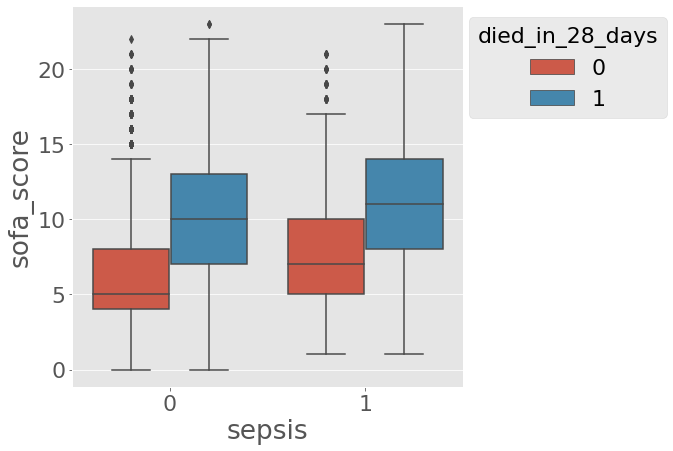

In [494]:
import seaborn as sns 
plt.figure(figsize=(7,7))
plot=sns.boxplot(x="sepsis", y="sofa_score", hue='died_in_28_days',data=df_final)
sns.move_legend(plot, "upper right", bbox_to_anchor=(1.55, 1))

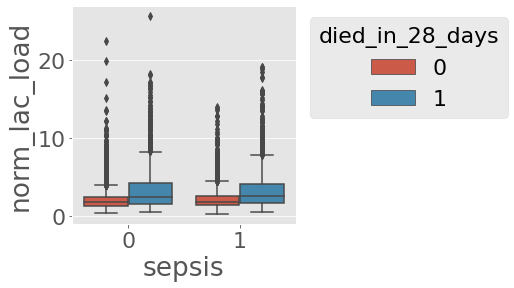

In [506]:
plt.figure(figsize=(4,4))
plot=sns.boxplot(x="sepsis", y="norm_lac_load", hue='died_in_28_days',data=df_final)
sns.move_legend(plot, "upper right", bbox_to_anchor=(2, 1))

In [570]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

In [578]:
from pandas.core.arrays.sparse import array

# Normalized lactate load all patients

# Copy dataset and drop na's
data = df_final.copy()
data = data.dropna()

#define the predictor variables and the response variable
X = np.array(data['norm_lac_load']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_1 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_1}')

AUROC: 0.7070383636648697


In [579]:
# Maximum lactate all patients

#define the predictor variables and the response variable
X = np.array(data['max_lac']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_2 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_2}')

AUROC: 0.6869278917471688


In [580]:
# Mean lactate all patients

#define the predictor variables and the response variable
X = np.array(data['mean_lac']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_3 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_3}')

AUROC: 0.6970424239500544


In [581]:
# Normalized lactate load sepsis patients

# Copy dataset and drop na's
data = df_final.loc[df_final['sepsis']==1]
data = data.dropna()

#define the predictor variables and the response variable
X = np.array(data['norm_lac_load']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_4 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_4}')

AUROC: 0.7146382943421271


In [582]:
# Maximum lactate sepsis patients

#define the predictor variables and the response variable
X = np.array(data['max_lac']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_5 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_5}')

AUROC: 0.699622531939605


In [583]:
# Mean lactate sepsis patients

#define the predictor variables and the response variable
X = np.array(data['mean_lac']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_6 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_6}')

AUROC: 0.7054919528787125


In [584]:
# Normalized lactate load non-sepsis patients

# Copy dataset and drop na's
data = df_final.loc[df_final['sepsis']==0]
data = data.dropna()

#define the predictor variables and the response variable
X = np.array(data['norm_lac_load']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_7 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_7}')

AUROC: 0.7000638406537283


In [585]:
# Maximum lactate non-sepsis patients

#define the predictor variables and the response variable
X = np.array(data['max_lac']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_8 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_8}')

AUROC: 0.6758810010214503


In [586]:
# Mean lactate non-sepsis patients

#define the predictor variables and the response variable
X = np.array(data['mean_lac']).reshape(-1,1)
y = np.array(data['died_in_28_days'])

clf = LogisticRegression()

clf.fit(X, y.ravel())

# evaluate on test set with best params
y_prob = clf.predict_proba(X)[:, 1]
auroc_9 = roc_auc_score(y, y_prob)
print(f'AUROC: {auroc_9}')

AUROC: 0.6883171603677221


In [591]:
pip install tabulate
from tabulate import tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [604]:
table = [[' ','All Patients', 'Sepsis Patients', 'Non-Sepsis Patients'], ['Normalized Lactate Load', auroc_1, auroc_4, auroc_7], 
         ['Maximum Lactate', auroc_2, auroc_5, auroc_8], ['Mean Lactate', auroc_3, auroc_6, auroc_9]]

print(tabulate(table, tablefmt='fancy_grid'))

╒═════════════════════════╤════════════════════╤════════════════════╤═════════════════════╕
│                         │ All Patients       │ Sepsis Patients    │ Non-Sepsis Patients │
├─────────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ Normalized Lactate Load │ 0.7070383636648697 │ 0.7146382943421271 │ 0.7000638406537283  │
├─────────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ Maximum Lactate         │ 0.6869278917471688 │ 0.699622531939605  │ 0.6758810010214503  │
├─────────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ Mean Lactate            │ 0.6970424239500544 │ 0.7054919528787125 │ 0.6883171603677221  │
╘═════════════════════════╧════════════════════╧════════════════════╧═════════════════════╛
